**Nom :** GAO 

**Prénom :**Ting

<h1>Propagation de la fumée dans la chambre<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Présentation-du-problème" data-toc-modified-id="Présentation-du-problème-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Présentation du problème</a></span></li><li><span>
<a href="#Démarche" data-toc-modified-id="Démarche"><span class="toc-item-num">2&nbsp;&nbsp;</span>1D : Démarche</a></span><ul class="toc-item"><li><span>
<a href="#Cas-générale-de-résolution" data-toc-modified-id="#Cas-générale-de-résolution-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cas générale de résolution</a></span></li><li><span><a href="#L'influence-de-type-de-repas" data-toc-modified-id="L'influence-de-type-de-repas-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>L'influence de type de repas</a></span></li><li><span><a href="#L'influence-du-vent-(variable-aléatoire)" data-toc-modified-id="L'influence-du-vent-(variable-aléatoire)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>L'influence du vent (variable aléatoire)</a></span></li></ul></li><li><span><a href="#Bibliographie" data-toc-modified-id="#Bibliographie-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bibliographie</a></span></li>

# Présentation du problème

Pendant cette période de fermeture de l'école, beaucoup d'élève en confinement à CentraleSupélec cuisinent eux-même et on entend plus souvent le son des decteurs de fumée. Dans ce projet, on va s'intéresser à la propagation de la fumée dans une cuisine. On modélisera ce phénomène par l'équation de Navier-Stokes dans la mécanique des milieux continus: 
\begin{equation}
\frac{du}{dt}=-(r\cdot\nabla)u +S -\nabla (\kappa\nabla u) 
\end{equation}

où $r$ sigifie la vitesse de fluide, $u$ la concentration de fumée, $S$ la concentration originale, $\kappa$ le coefficient de diffusivité, pour la simplification, on néglige la concentration originale $(S=0)$, le vent reste stationnaire dans la chambre ($r=0$ à l'intérieur de $\Omega$)par ailleurs, on se place dans le cas stationnaire et $\kappa$ reste constante.

Dans la suite, on va simuler une chambre à résidence 4A de Césal, on considère que la concentration $u$ est indépendante de la hauteur, la chambre peut ainsi être représentée par une rectangle $\Omega=ABCD$ avec conditions aux limites mêlées. La concentration $u$ reste invariante $u_0$ au-dessus des plaques à induction. Les plaques occupent une place de carré dont le centre est $x=0.9, y=1.9$ et la longeur de côté est de 0,5 mètre, la fenêtre se situe au fond de la chambre et mesure 2 mètres de largeur.La position du détecteur de fumée est $x=3, y=2.5$

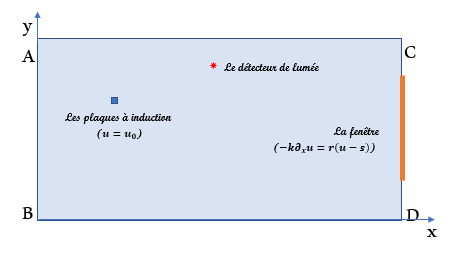

Notre équation devient ainsi :

\begin{equation}\begin{cases}
-\nabla (k\nabla u)=0 \qquad \mbox{ sur }\Omega\\ 
(CL)\begin{cases}
-\kappa\partial_{x}u=0 \qquad \mbox{ sur }[AB]\\
-\kappa\partial_{y}u=0 \qquad \mbox{ sur }[BC]\\
u=u_0 \qquad \mbox{ quand } x \in [0.8,1],y\in[1.8,2]\\
-\kappa\partial_{x}u=r*(u-S) \qquad \mbox{ quand } y\in [0.5,2,5] \mbox{ sur } [CD]\\
-\kappa\partial_{x}u=0 \qquad \mbox{ quand }y\not\in [0.5,2,5] \mbox{ sur } [CD]\\
-\kappa\partial_{y}u=0 \qquad \mbox{ sur }[DA]\\
\end{cases}\end{cases}\end{equation}

où les valeurs numériques sont

\begin{equation*}\begin{cases}
X=d(B,C)=d(D,A)=6\,m\\
Y=d(A,B)=d(C,D)=3\,m\\
\kappa=0.05m^{2}.s^{-1}\\
\end{cases}\end{equation*}
et S est la concentration de la fumée de la'autre côté de la fenêtre qui est considérée égale à 0 et $r$ siginifie la vitesse du vent à la fenêtre.


#Démarche

##Cas générale de résolution

Ici on essaye de résoudre notre problème en défissant les paramètres de manière définitive, on va proposer d'abord la fonctionnalité *solver_bcs*, dans cette fonctionnalité, on prend $\kappa$, $u_0$, $r$ comme paramètres d'entrée, et donne $u$ comme sortie. L'explications des codes sont notées comme notation au-dessous.

In [0]:
from fenics import *
from dolfin import *
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [0]:
def solver_bcs(u_0, r, Nx, Ny, degree=1):
    
    # Create mesh and define function space
    mesh = RectangleMesh(Point(0, 0), Point(6, 3), Nx, Ny)
    V = FunctionSpace(mesh, 'P', degree)

    # Define boundary subdomains
    tol = 1e-14

    #Define boundaries
    class BoundaryX0(SubDomain):
      def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0, tol)

    class BoundaryX1(SubDomain):
      def inside(self, x, on_boundary):
        return x[0]<=1+tol and x[0] >= 0.8+tol and x[1] >= 1.8 + tol and x[1] <= 2 + tol #subdomain of the induction hobs

    class BoundaryX2_1(SubDomain):
      def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 6, tol) and x[1]<=2.5+tol and x[1]>=0.5-tol #subdomain of the window

    class BoundaryX2_2(SubDomain):
      def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 6, tol) and (x[1]>=2.5-tol or x[1]<=0.5+tol) 

    class BoundaryY0(SubDomain):
      def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0, tol)

    class BoundaryY1(SubDomain):
      def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 3, tol)
    

    # Mark boundaries
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    boundary_markers.set_all(9999)
    bx0 = BoundaryX0()
    bx1 = BoundaryX1()
    bx2_1 = BoundaryX2_1()
    bx2_2 = BoundaryX2_2()
    by0 = BoundaryY0()
    by1 = BoundaryY1()
    bx0.mark(boundary_markers,0)
    bx1.mark(boundary_markers,1)
    bx2_1.mark(boundary_markers,2)
    bx2_2.mark(boundary_markers,3)
    by0.mark(boundary_markers,4)
    by1.mark(boundary_markers,5)
    
    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)
    
    #Define boundary condiations
    variables = [Constant(u_0), Constant(r)]
    variables = [sym.printing.ccode(var) for var in variables]
    variables = [Expression(var,degree = 2) for var in variables]
    u_0, r = variables
    boundary_conditions = {
      0:{'Neumann':Constant(0)}, 
      1:{'Dirichlet':u_0}, 
      2:{'Robin':(r,Constant(0))},
      3:{'Neumann':Constant(0)},
      4:{'Neumann':Constant(0)},
      5:{'Neumann':Constant(0)}
      }

    # Collect Dirichlet conditions
    bcs = []
    bc = DirichletBC(V, boundary_conditions[1]['Dirichlet'],boundary_markers, 1)
    bcs.append(bc)

    # Collect Robin integrals
    integrals_R = []
    r, s = boundary_conditions[2]['Robin']
    integrals_R.append(r*(u - s)*v*ds(2))

    # In our case, the Neumann condition is 0, so we don't have to collect it
    
    # Sum integrals to define variational problem
    kappa = Constant(0.05)
    f = Constant(0)
    F = kappa*dot(grad(u), grad(v))*dx + \
        sum(integrals_R) - f*v*dx
    a, L = lhs(F), rhs(F)

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)
    type
    return u

On prend $\kappa$ égal à 0.05 $m^{2}.s^{-1}$, $u_0$ égal à 9 $mg.m^{-3}$, la fenêtre est fermée, c'est-à-dire que $r=0$. on va faire fonctionner notre *slover* et obtient la concentration à la position de detecteur de fuméé :

La concentrarion de la fumée détectée est : 9.000000000155945 mg.m^{-3}


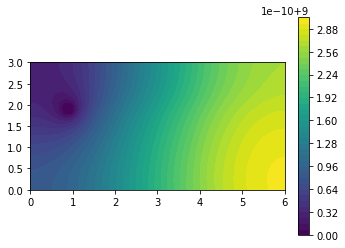

In [14]:
import matplotlib.pyplot as plt
def solver_u():
  u = solver_bcs(9, 0, 500, 500)
  plu=plot(u)
  plt.colorbar(plu,fraction=0.2, pad=0.04)
  detect_point = (3,2.5)
  print("La concentrarion de la fumée détectée est : %s mg.m^{-3}"%(u(detect_point)))

solver_u()

On voit bien que la concentration la plus dense reste autour de la fenêtre car la fumée n'a pas d'endroit à diffuser, par ailleurs, avec la fenêtre fermée, la concentration de fumée détectée est un peu plus élevée que $u_0$. Si on prend 5 $mg.m^{-3}$ comme seuil d'alarme, le détecteur de fumée va bien alarmer.

##L'influence du type de repas

Quand on cuisine différents repas, on émet différents degrés de concentration de fumée, voici quelques exemples:

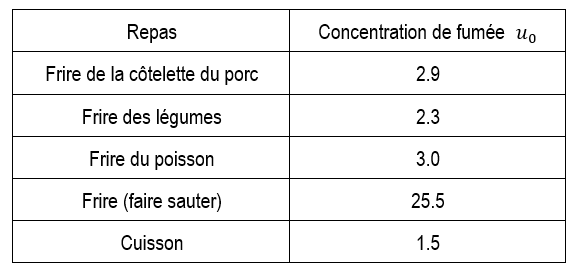


On suppose tout d'abord que la fenêtre est ouverte et $r=0 \; m.s^{−1}$, on obtient ainsi des concentrations de fumée détectées différentes pour différents repas.

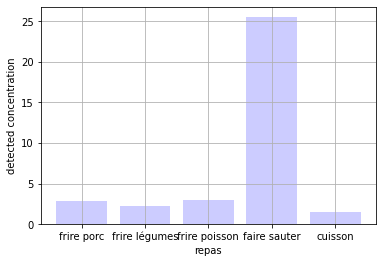

In [15]:
import matplotlib.pyplot as plt
repas = [2.9, 2.3, 3.0, 25.5, 1.5]
name_list = ["frire porc","frire légumes","frire poisson","faire sauter","cuisson"]
detect_point = (3,2.5)
smoke_concentration = []
for u_0 in repas :
  u = solver_bcs(u_0, 0, 500, 500)
  detect_concentration = u(detect_point)
  smoke_concentration.append(u(detect_point))

plt.grid(True)
plt.bar(range(len(smoke_concentration)), smoke_concentration,color='blue',alpha = 0.2,tick_label=name_list)
plt.xlabel("repas")
plt.ylabel("detected concentration")
plt.show()



Supposons maintenant que la fenêtre est ouverte et $r = 10 m.s^{-1}$, on on s'intéresse encore une fois à la concentration de fumée détectée pour différents repas.

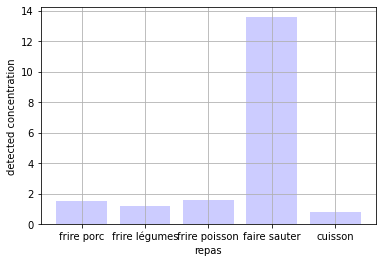

In [16]:
import matplotlib.pyplot as plt
repas = [2.9, 2.3, 3.0, 25.5, 1.5]
name_list = ["frire porc","frire légumes","frire poisson","faire sauter","cuisson"]
detect_point = (3,2.5)
smoke_concentration = []
for u_0 in repas :
  u = solver_bcs(u_0, 10, 500, 500)
  detect_concentration = u(detect_point)
  smoke_concentration.append(u(detect_point))

plt.grid(True)
plt.bar(range(len(smoke_concentration)), smoke_concentration,color='blue',alpha = 0.2,tick_label=name_list)
plt.xlabel("repas")
plt.ylabel("detected concentration")
plt.show()




De ce résultat, on peut faire deux remarques :

1.il est plus facile de déclencher le détecteur quand on cuisine en faisant sauter les ingrédients

2.en ouvrant la fenêtre, la concentration de fumée déctectée a bien descendu

##L'influence du vent (variable aléatoire)

Maintenant on considère que la fenêtre est ouverte, on prend sur la vitesse du vent pendant quinze jours (ces données sont accessibles sur internet) on utilise ces données pour générer une distribution de la vitesse de vent. 

**Attention!!!** *Quand vous exécutez les codes dans la suite, si votre ordinateur vous dit 'no module named scipy', vous devrez installer scipy dans votre ordinateur ou supprimer les codes notées dans la notation, pourtant, en les supprimant, vous ne pourriez plus voir la courbe y qui est la courbe normalisée des données du vent, mais cela n'a aucune influence des codes suivantes:)* 

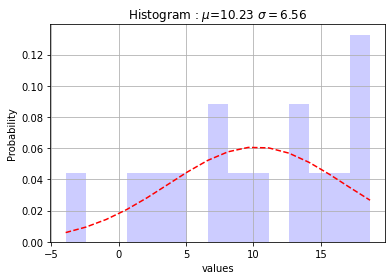

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm #to delete if you don't have scipy

#get the normal distribution
wind = np.array([12, 31, 21, 19, 11, 13, 18, 10, 10, 15, 17, 15, 17, 15, 14])
direction = np.array([163, 37, 54, 79, 201, 133, 90, 50, 10, 40, 50, 60, 60, 30, 20])#degree of deviation of wind direction from north
r=wind*(np.sin(direction*np.pi/180)) #suppose our chamber faces west

#calculate the average value
mu =np.mean(r)

#calulate the variance
sigma =np.std(r)

#draw the histogram
num_bins = len(r)
n, bins, patches = plt.hist(r, num_bins, density = 1, color='blue',alpha = 0.2,) 

#normalize the histogram 
y = norm.pdf(bins, mu, sigma) #to delete if you don't have scipy
plt.grid(True)
plt.plot(bins, y,'r--')#to delete if you don't have scipy
plt.xlabel('values') 
plt.ylabel('Probability') 
plt.title('Histogram : $\mu$=' + str(round(mu,2)) + ' $\sigma=$'+str(round(sigma,2))) 
plt.show()


Avec cette courbe normalisée, on va générer un ensemble avec 100 échantillons pour voir l'influence de la vitesse du vent $r$ sur $u$. On prend $u_0$ égal à  9 $mg.m^{-3}$. Puisque l'ensemble d'échantillonage est assez grand, l'exécution du programme va durer longtemps, je vous conseille de prendre un café et revenir après :) 

 100.00% loading...

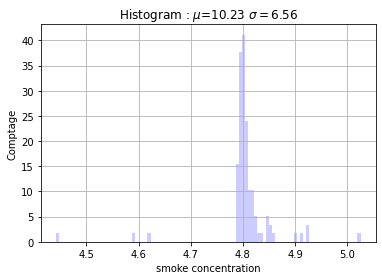

1.0 % possibilité que le détecteur sonne.


In [18]:
#calculate the detected concentration with different wind
import time

#generate 100 samples
sample_Num = 100
r = np.random.normal(mu, sigma, sample_Num)*1000/3600
smoke_concentration = []
detect_point = (3,2.5)
alarm_count = 0
n = 0

#for each sample, calculate the detected concentration
for r_ in r:
  u = solver_bcs(9, r_, 500, 500)
  detect_concentration = u(detect_point)
  smoke_concentration.append(detect_concentration)
  #if the dectetor alarms
  if detect_concentration >= 5:
    alarm_count += 1
  #renew the progress bar
  n += 1
  time.sleep(0.2)
  print("\r {:.2%} loading...".format(n/100), end="")

#Create the histogram  
n, bins, patches = plt.hist(smoke_concentration, len(smoke_concentration), density=1, color='blue',alpha = 0.2)  
plt.grid(True)
plt.xlabel('smoke concentration') 
plt.ylabel('Comptage') 
plt.title('Histogram : $\mu$=' + str(round(mu,2)) + ' $\sigma=$'+str(round(sigma,2))) 
plt.show()
print(round((alarm_count/len(smoke_concentration)*100),2),"% possibilité que le détecteur sonne.")

On constate que l'influence du vent $r>0$ a bien descendu la probabilité que le détecteur sonne, pourtant,si la direction du vent est à l'opposé, c'est-à-dire que $r<0$ et le vent rentre dans la chambre, alors est-ce que la concentration va devenir plus élevée ?  Pour le vérifier, on va juste changer la valeur moyenne $\mu$ en prenant $\mu<0$, et voici le code :

 100.00% loading...

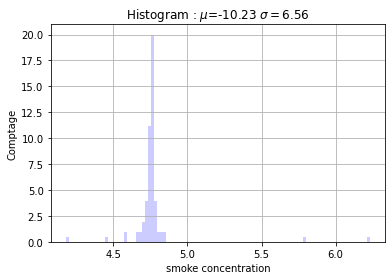

2.0 % possibilité que le détecteur sonne.


In [19]:
sample_Num = 100
r = np.random.normal(-mu, sigma, sample_Num)*1000/3600
smoke_concentration = []
detect_point = (3,2.5)
alarm_count = 0
n = 0

for r_ in r:
  u = solver_bcs(9, r_, 500, 500)
  detect_concentration = u(detect_point)
  smoke_concentration.append(detect_concentration)
  if detect_concentration >= 5:
    alarm_count += 1
  n += 1
  time.sleep(0.2)
  print("\r {:.2%} loading...".format(n/100), end="")
 
n, bins, patches = plt.hist(smoke_concentration, len(smoke_concentration), density=1, color='blue',alpha = 0.2)  
plt.grid(True)
plt.xlabel('smoke concentration') 
plt.ylabel('Comptage') 
plt.title('Histogram : $\mu$=' + str(round(-mu,2)) + ' $\sigma=$'+str(round(sigma,2))) 
plt.show()
print(round((alarm_count/len(smoke_concentration)*100),2),"% possibilité que le détecteur sonne.")

On obeserve que avac la direction du vent $r<0$, la probalilité que le détecteur sonne devient un peu plus élevée que la probabilité de $r>0$.  

En comparaisant avec la première partie, on peut conclure que quelque soit la direction du vent, ouvrir la fenêtre nous permet de diminuer la chance que le détecteur sonne!

# Biliographie

https://pubs.acs.org/doi/abs/10.1021/es103080p 

https://zhuanlan.zhihu.com/p/37241768

https://www.timeanddate.com/weather/france/paris/historic?month=1&year=2020

http://www-users.math.umn.edu/~arnold/8445/fenics-getting-started.pdf